In [ ]:
!pip install pandas networkx matplotlib spacy scipy
!pip install -U spacy
!python -m spacy download pt_core_news_lg
!pip install liac-arff
!pip install pyarrow
!pip install nltk
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB ? eta 0:00:000:00:0100:03
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11768 sha256=2a8b548353c3e4987e01727376a81d6406aa33041f790d2d3ee15385e9016aee
  Stored in directory: /home/loli/.cache/pip/wheels/a9/ac/cf/c2919807a5c623926d217c0a18eb5b457e5c19d242c3b5963a
Successfully built liac-arff


In [31]:
import pandas as pd              # Para manipular os dados (CSVs, DataFrames)
import re                        # Para usar expressões regulares na limpeza do texto (remover @)
import networkx as nx            # Para criar e manipular os grafos
import matplotlib.pyplot as plt  # Para visualizar os grafos
import spacy                     # A biblioteca principal para processamento de linguagem em português
from itertools import combinations
import spacy
import nltk
from nltk.corpus import stopwords
import networkx as nx
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import arff
import os

In [2]:
# Carregar o modelo de linguagem em português do spaCy
# Isso substitui os downloads do NLTK
try:
    nlp = spacy.load('pt_core_news_lg')
    print("Bibliotecas essenciais e modelo 'pt_core_news_lg' do spaCy carregados com sucesso!")
except OSError:
    print("Modelo 'pt_core_news_sm' não encontrado. Por favor, execute a célula de instalação:")
    print("!python -m spacy download pt_core_news_lg")

nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

Bibliotecas essenciais e modelo 'pt_core_news_lg' do spaCy carregados com sucesso!


[nltk_data] Downloading package stopwords to /home/loli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
offComBR_01 = './data/01-raw/offComBR/OffComBR3.arff'
# Carrega o arquivo .arff
# Carrega o ARFF com liac-arff
with open(offComBR_01, 'r', encoding='utf-8') as f:
    arff_data = arff.load(f)

# Converte para DataFrame
df_arff = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])

print("--- Pré-visualização dos dados do .arff ---")
print(df_arff.head())

caminho_arff_saida = './data/01-raw/offComBR/offComBR.csv'
# Salva o DataFrame como .csvcaminho_csv_saida_1
df_arff.to_csv('./data/01-raw/offComBR/offComBR.csv', index=False, encoding='utf-8')

print(f"\n[SUCESSO] Arquivo '{offComBR_01}' convertido para '{caminho_arff_saida}'")

--- Pré-visualização dos dados do .arff ---
  @@class                                           document
0     yes               Votaram no PEZAO Agora tomem no CZAO
1      no  cuidado com a poupanca pessoal Lembram o que a...
2      no  Sabe o que eu acho engracado os nossos governa...
3      no              Podiam retirar dos lucros dos bancos 
4      no  CADE O GALVAO PRA NARRAR AGORA   FALIIIIUUUUUU...

[SUCESSO] Arquivo './data/01-raw/offComBR/OffComBR3.arff' convertido para './data/01-raw/offComBR/offComBR.csv'


In [7]:
olidBR_01 = './data/01-raw/olidBR/test-00000-of-00001-914dbee7561d2266.parquet'
df_parquet = pd.read_parquet(olidBR_01)
print("--- Pré-visualização dos dados do .parquet ---")
print(df_parquet.head())

caminho_parquet_saida = './data/01-raw/olidBR/olidBR.csv'
# Salva o DataFrame como .csv
df_parquet.to_csv(caminho_parquet_saida, index=False, encoding='utf-8')

print(f"\n[SUCESSO] Arquivo '{olidBR_01}' convertido para '{caminho_parquet_saida}'")

--- Pré-visualização dos dados do .parquet ---
                                 id  \
0  da19df36730945f08df3d09efa354876   
1  80f1a8c981864887b13963fed1261acc   
2  80eee9db811c4ea4b2ddb7863d12c5fe   
3  2f67025f913e4a6292e3d000d9e2b5a8   
4  e64148caa4474fc79298e01d0dda8f5e   

                                                text is_offensive is_targeted  \
0  USER Adorei o comercial também Jesus. Só achei...          OFF         UNT   
1  Cara isso foi muito babaca geral USER conhece ...          OFF         TIN   
2                           Quem liga pra judeu kkkk          OFF         UNT   
3  Se vc for porco, folgado e relaxado, você não ...          OFF         UNT   
4    USER Toma no cu é vitamina como tu e tua prima.          OFF         TIN   

  targeted_type                                        toxic_spans  health  \
0          None  [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 6...   False   
1           GRP  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   False 

In [5]:
datasets_01 = {
    "hateBR": './data/01-raw/hateBR/HateBRXplain.csv',
    "offComBR": './data/01-raw/offComBR/offComBR.csv',
    "olidBR": './data/01-raw/olidBR/olidBR.csv',
    "fortuna": './data/01-raw/fortuna/2019-05-28_portuguese_hate_speech_binary_classification.csv',
    "toLDBR": './data/01-raw/toLDBR/ToLD-BR.csv',
    "tuPyE": './data/01-raw/tuPyE/binary_test.csv'
}

# Lê e conta as instâncias
print("--- Total de instâncias por dataset ---")
for nome, caminho in datasets_01.items():
    try:
        df = pd.read_csv(caminho)
        print(f"\n{nome} ({df.shape[0]} instâncias):")
        print(list(df.columns))
    except Exception as e:
        print(f"{nome}: Erro ao ler o arquivo - {e}")

--- Total de instâncias por dataset ---

hateBR (7000 instâncias):
['id', 'comment', 'offensive_label', 'link_post', 'rationales_annotator1', 'rationales_annotator2']

offComBR (1033 instâncias):
['class', 'document']

olidBR (1738 instâncias):
['id', 'text', 'is_offensive', 'is_targeted', 'targeted_type', 'toxic_spans', 'health', 'ideology', 'insult', 'lgbtqphobia', 'other_lifestyle', 'physical_aspects', 'profanity_obscene', 'racism', 'religious_intolerance', 'sexism', 'xenophobia']

fortuna (5670 instâncias):
['text', 'hatespeech_comb', 'hatespeech_G1', 'annotator_G1', 'hatespeech_G2', 'annotator_G2', 'hatespeech_G3', 'annotator_G3']

toLDBR (21000 instâncias):
['text', 'homophobia', 'obscene', 'insult', 'racism', 'misogyny', 'xenophobia', 'hate']

tuPyE (8734 instâncias):
['source', 'text', 'researcher', 'year', 'aggressive', 'hate']


In [ ]:
def cont_categorias(coluna_alvo, nome, value):
    df = pd.read_csv(datasets_01[nome])
    total = (df[coluna_alvo] == value).sum()
    print(f"{nome}: {total} instâncias na {coluna_alvo}")

cont_categorias('offensive_label','hateBR', 1)
cont_categorias('is_offensive','olidBR', 'OFF')
cont_categorias('hatespeech_comb','fortuna', 1)

colunas_odio = ['homophobia', 'obscene', 'insult', 'racism', 'misogyny', 'xenophobia']
df = pd.read_csv(datasets_01['toLDBR'])
df['hate'] = df[colunas_odio].any(axis=1).astype(int)
df.to_csv('./data/01-raw/toLDBR/ToLD-BR.csv', index=False, encoding='utf-8')
cont_categorias('hate','toLDBR', 1)

cont_categorias('hate','tuPyE', 1)

hateBR: 3500 instâncias na offensive_label
olidBR: 1484 instâncias na is_offensive
fortuna: 1788 instâncias na hatespeech_comb
toLDBR: 9255 instâncias na hate
tuPyE: 1051 instâncias na hate


In [3]:
datasets_02 = {
     "hateBR": {
        'col_mensagem': 'comment',
        'col_rotulo': 'offensive_label',
        'saida': './data/02-cleaned/hateBR/HateBRXplain.csv'
    },
    "offComBR": {
        'col_mensagem': 'document',             
        'col_rotulo': 'class',
        'saida': './data/02-cleaned/offComBR/offComBR.csv'
    },
    "olidBR": {
        'col_mensagem': 'text',
        'col_rotulo': 'is_offensive',
        'saida': './data/02-cleaned/olidBR/olidBR.csv'
    },
    "fortuna": {
        'col_mensagem': 'text',
        'col_rotulo': 'hatespeech_comb',
        'saida': './data/02-cleaned/fortuna/fortuna.csv'
    },
    "toLDBR": {
        'col_mensagem': 'text',
        'col_rotulo': 'hate',
        'saida': './data/02-cleaned/toLDBR/ToLD-BR.csv'
    },
    "tuPyE": {
        'col_mensagem': 'text',
        'col_rotulo': 'hate',
        'saida': './data/02-cleaned/tuPyE/tuPyE.csv'
    }
}

In [6]:
def uniformizar_csv(nome, caminho, col_mensagem, col_rotulo, saida):
    try:
        df = pd.read_csv(caminho)

        # Verifica se as colunas estão no DataFrame
        if col_mensagem in df.columns and col_rotulo in df.columns:
            df_padronizado = df[[col_mensagem, col_rotulo]].rename(columns={
                col_mensagem: 'mensagem',
                col_rotulo: 'odio'
            })

            # Caminho de saída
            os.makedirs(os.path.dirname(saida), exist_ok=True)
            caminho_saida = os.path.join(saida, f"{nome}.csv")
            df_padronizado.to_csv(saida, index=False, encoding='utf-8')

            print(f"[✓] {nome}: {df_padronizado.shape[0]} instâncias salvas em '{caminho_saida}'")
        else:
            print(f"[✗] {nome}: colunas '{col_mensagem}' e/ou '{col_rotulo}' não encontradas.")

    except Exception as e:
        print(f"[ERRO] {nome}: {e}")
        
for nome, config in datasets_02.items():
    uniformizar_csv(
        nome,
        datasets_01[nome],
        config['col_mensagem'],
        config['col_rotulo'],
        config['saida']
    )

[✓] hateBR: 7000 instâncias salvas em './data/02-cleaned/hateBR/HateBRXplain.csv/hateBR.csv'
[✓] offComBR: 1033 instâncias salvas em './data/02-cleaned/offComBR/offComBR.csv/offComBR.csv'
[✓] olidBR: 1738 instâncias salvas em './data/02-cleaned/olidBR/olidBR.csv/olidBR.csv'
[✓] fortuna: 5670 instâncias salvas em './data/02-cleaned/fortuna/fortuna.csv/fortuna.csv'
[✓] toLDBR: 21000 instâncias salvas em './data/02-cleaned/toLDBR/ToLD-BR.csv/toLDBR.csv'
[✓] tuPyE: 8734 instâncias salvas em './data/02-cleaned/tuPyE/tuPyE.csv/tuPyE.csv'


In [3]:
datasets_03 = {
    "hateBR": './data/03-processed/hateBR/HateBRXplain.csv',
    "offComBR": './data/03-processed/offComBR/offComBR.csv',
    "olidBR": './data/03-processed/olidBR/olidBR.csv',
    "fortuna": './data/03-processed/fortuna/fortuna.csv',
    "toLDBR": './data/03-processed/toLDBR/ToLD-BR.csv',
    "tuPyE": './data/03-processed/tuPyE/tuPyE.csv'
}

In [8]:
def limpar_e_lematizar(texto: str) -> str:
    """
    Limpa o texto e aplica lematização com spaCy para português.
    Remove menções, hashtags, emojis, stopwords e pontuações.
    """
  # Remove URLs
    texto = re.sub(r'http\S+|www\S+', '', texto)
    # Remove menções (@usuario)
    texto = re.sub(r'@\w+', '', texto)
    # Remove hashtags (#assunto)
    texto = re.sub(r'#\w+', '', texto)
    # Remove a marcação de "RT" (Retweet)
    texto = re.sub(r'RT', '', texto)
    # Remove caracteres de nova linha (\n) e os substitui por espaço
    texto = re.sub(r'\n', ' ', texto)
    # Remove caracteres especiais, pontuações e números, deixando apenas letras e espaços
    texto = re.sub(r'[^\w\s]', '', texto)
    # Remove espaços em branco extras (deixa apenas um espaço entre as palavras)
    texto = re.sub(r'\s+', ' ', texto).strip()
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Símbolos e pictogramas
        u"\U0001F680-\U0001F6FF"  # Transporte e mapas
        u"\U0001F1E0-\U0001F1FF"  # Bandeiras
        u"\U00002500-\U00002BEF"  # Caracteres diversos
        u"\U00002700-\U000027BF"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    texto = emoji_pattern.sub(r'', texto)

    # --- Remoção de Stop Words ---
    # 1. Converte o texto para minúsculas e divide em palavras (tokens)
    palavras = texto.lower().split()

    # Processa o texto com o modelo spaCy
    doc = nlp(texto)

    # 2. Remove as stop words e lematização
    lemmas = [
        token.lemma_ for token in doc 
        if not token.is_punct and not token.is_space and not token.is_stop
    ]
    return " ".join(lemmas)

In [ ]:
for nome in datasets_03:
    caminho_entrada = datasets_02[nome]['saida']
    caminho_saida = datasets_03[nome]

    try:
        df = pd.read_csv(caminho_entrada)

        if 'mensagem' not in df.columns:
            print(f"[⚠️] {nome}: coluna 'mensagem' não encontrada. Pulando.")
            continue

        print(f"[→] Processando '{nome}' ({len(df)} linhas)...")

        df['mensagem'] = df['mensagem'].astype(str).apply(limpar_e_lematizar)

        diretorio = os.path.dirname(caminho_saida)
        if diretorio:
            os.makedirs(diretorio, exist_ok=True)

        df.to_csv(caminho_saida, index=False, encoding='utf-8')
        print(f"[✓] '{nome}' salvo em {caminho_saida} .\n")

    except Exception as e:
        print(f"[ERRO] ao processar '{nome}': {e}\n")

[→] Processando 'hateBR' (7000 linhas)...
[✓] 'hateBR' salvo em ./data/03-processed/hateBR/HateBRXplain.csv com coluna 'texto_processado'.

[→] Processando 'offComBR' (1033 linhas)...
[✓] 'offComBR' salvo em ./data/03-processed/offComBR/offComBR.csv com coluna 'texto_processado'.

[→] Processando 'olidBR' (1738 linhas)...
[✓] 'olidBR' salvo em ./data/03-processed/olidBR/olidBR.csv com coluna 'texto_processado'.

[→] Processando 'fortuna' (5670 linhas)...
[✓] 'fortuna' salvo em ./data/03-processed/fortuna/fortuna.csv com coluna 'texto_processado'.

[→] Processando 'toLDBR' (21000 linhas)...
[✓] 'toLDBR' salvo em ./data/03-processed/toLDBR/ToLD-BR.csv com coluna 'texto_processado'.

[→] Processando 'tuPyE' (8734 linhas)...
[✓] 'tuPyE' salvo em ./data/03-processed/tuPyE/tuPyE.csv com coluna 'texto_processado'.



In [4]:
hurtlex_01 = pd.read_csv('./data/01-raw/hurtlex/hurtlex_PT.tsv', sep='\t')
caminho_saida = './data/02-cleaned/hurtlex/hurtlex.csv'
diretorio = os.path.dirname(caminho_saida)
if diretorio:
    os.makedirs(diretorio, exist_ok=True)
hurtlex_01.to_csv(caminho_saida, index=False)
print(f"hatebase: {hurtlex_01['lemma'].count()} instâncias")

caminho_saida = './data/02-cleaned/hurtlex/hurtlex.csv'
diretorio = os.path.dirname(caminho_saida)
if diretorio:
    os.makedirs(diretorio, exist_ok=True)
hurtlex_01[hurtlex_01['level'] == 'conservative'].to_csv(caminho_saida, index=False)

caminho_saida = './data/03-processed/hurtlex/hurtlex.csv'
hurtlex_02 = pd.read_csv('./data/02-cleaned/hurtlex/hurtlex.csv')
lemmas_processados = []
for doc in nlp.pipe(hurtlex_02['lemma'].astype(str), batch_size=50):
    palavras = [
        token.lemma_ for token in doc
        if not token.is_punct and not token.is_space and not token.is_stop
    ]
    lemmas_processados.append(" ".join(palavras))
hurtlex_02['lemma'] = lemmas_processados
hurtlex_02.to_csv(caminho_saida, index=False)

hatebase: 3901 instâncias


In [5]:
hurtlex_03 = pd.read_csv(caminho_saida)
print(f"hatebase: {hurtlex_03['lemma'].duplicated().sum()} instâncias duplicadas")
hatebase = hurtlex_03.groupby('lemma').agg('max').to_dict(orient='index')
print(f"hatebase: {len(hatebase)} instâncias após processamento")

hatebase: 680 instâncias duplicadas
hatebase: 892 instâncias após processamento


In [6]:
# A função de montar o grafo permanece a mesma
def grafo_de_coocorrencia(series_texto: pd.Series, hatebase: dict) -> nx.Graph:
    categorias = ['ps', 'rci', 'pa', 'ddf', 'ddp', 'dmc', 'is', 'or', 'an', 'asm', 'asf', 'pr', 'om', 'qas', 'cds', 're', 'svp']
    G = nx.Graph()
    
    for texto in series_texto:
        palavras = texto.split()
        
        for palavra in palavras:
            if palavra not in G:
                if palavra in hatebase:
                    attrs = {'odio': 1}
                    for cat in categorias:
                        attrs[cat] = int(hatebase[palavra].get(cat, 0))
                else:
                    attrs = {'odio': 0}
                    for cat in categorias:
                        attrs[cat] = 0
                G.add_node(palavra, **attrs)
        
        for i in range(len(palavras) - 1):
            w1, w2 = palavras[i], palavras[i+1]
            if G.has_edge(w1, w2):
                G[w1][w2]['weight'] += 1
            else:
                G.add_edge(w1, w2, weight=1)
                
    return G

In [8]:
def salvar_grafo(grafo: nx.Graph, nome_dataset: str, pasta_saida: str = './data/04-graph', formato: str = 'gexf'):
    """
    Salva o grafo com nome baseado no dataset fornecido.
    
    Parâmetros:
        grafo (nx.Graph): O grafo a ser salvo
        nome_dataset (str): Nome base do dataset (ex: 'hurtlex', 'twitter_clean', etc.)
        pasta_saida (str): Pasta onde o grafo será salvo
        formato (str): Formato do arquivo ('graphml', 'gexf', 'pkl')
    """
    
    # Garante que a pasta existe
    os.makedirs(pasta_saida, exist_ok=True)

    # Define nome do arquivo final
    caminho_saida = os.path.join(pasta_saida, f'{nome_dataset}.{formato}')

    # Converte atributos para tipos simples (por segurança)
    for _, data in grafo.nodes(data=True):
        for key in data:
            if isinstance(data[key], (bool, float)):
                data[key] = int(data[key])

    # Salva no formato desejado
    if formato == 'graphml':
        nx.write_graphml(grafo, caminho_saida)
    elif formato == 'gexf':
        nx.write_gexf(grafo, caminho_saida)
    elif formato == 'pkl':
        import pickle
        with open(caminho_saida, 'wb') as f:
            pickle.dump(grafo, f)
    else:
        raise ValueError(f"Formato '{formato}' não suportado.")

    print(f"Grafo salvo com sucesso em: {caminho_saida}")


In [9]:
for nome, caminho in datasets_03.items():
    print(f"Processando dataset: {nome}")
    
    try:
        df = pd.read_csv(caminho)

        if 'mensagem' not in df.columns:
            print(f"⚠️  Coluna 'mensagem' não encontrada em: {nome}. Pulando...")
            continue
        
        # REVISÃO: Adicionar .dropna() para evitar erros se houver mensagens vazias (NaN).
        mensagens_validas = df.dropna(subset=['mensagem'])['mensagem']

        if mensagens_validas.empty:
            print(f"⚠️  Nenhuma mensagem válida encontrada em: {nome}. Pulando...")
            continue
        
        # Cria o grafo com a nova função
        G = grafo_de_coocorrencia(mensagens_validas, hatebase)

        # Salva o grafo
        salvar_grafo(G, nome, formato='gexf')

    except FileNotFoundError:
        print(f"[ X ] Arquivo não encontrado para o dataset '{nome}' em: {caminho}")
    except Exception as e:
        print(f"[ X ] Ocorreu um erro inesperado ao processar '{nome}': {e}")

Processando dataset: hateBR
Grafo salvo com sucesso em: ./data/04-graph/hateBR.gexf
Processando dataset: offComBR
Grafo salvo com sucesso em: ./data/04-graph/offComBR.gexf
Processando dataset: olidBR
Grafo salvo com sucesso em: ./data/04-graph/olidBR.gexf
Processando dataset: fortuna
Grafo salvo com sucesso em: ./data/04-graph/fortuna.gexf
Processando dataset: toLDBR
Grafo salvo com sucesso em: ./data/04-graph/toLDBR.gexf
Processando dataset: tuPyE
Grafo salvo com sucesso em: ./data/04-graph/tuPyE.gexf


In [22]:
def nuvem_palavras(series_texto: pd.Series, hatebase: dict, titulo="Nuvem de Palavras"):
    # Converter para string e ignorar NaNs
    textos_limpos = series_texto.dropna().astype(str)

    # Juntar todos os textos
    texto_total = ' '.join(textos_limpos)

    # Tokenização simples
    palavras = texto_total.split()

    # Contar frequência das palavras
    from collections import Counter
    contagem = Counter(palavras)

    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    # Criar WordCloud (sem gerar imagem ainda)
    wc = WordCloud(width=800, height=400, background_color='white')

    # Gerar a imagem da nuvem a partir das frequências
    wc.generate_from_frequencies(contagem)

    # Função de cor: vermelho se palavra na hatebase, senão cinza
    def cor_personalizada(word, font_size, position, orientation, random_state=None, **kwargs):
        return 'red' if word in hatebase else 'gray'

    wc.recolor(color_func=cor_personalizada)

    # Plotar
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=16)
    plt.show()


Nuvem de Palavras dataset: hateBR


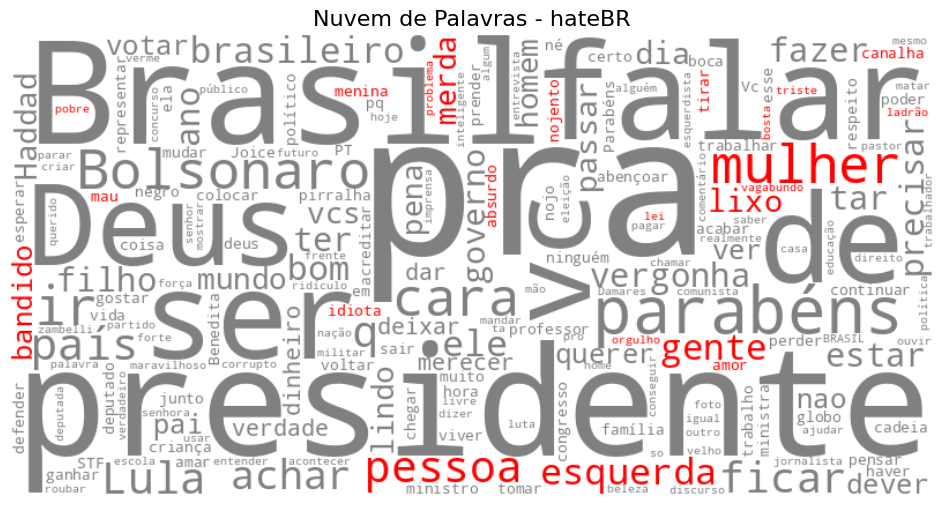

Nuvem de Palavras dataset: offComBR


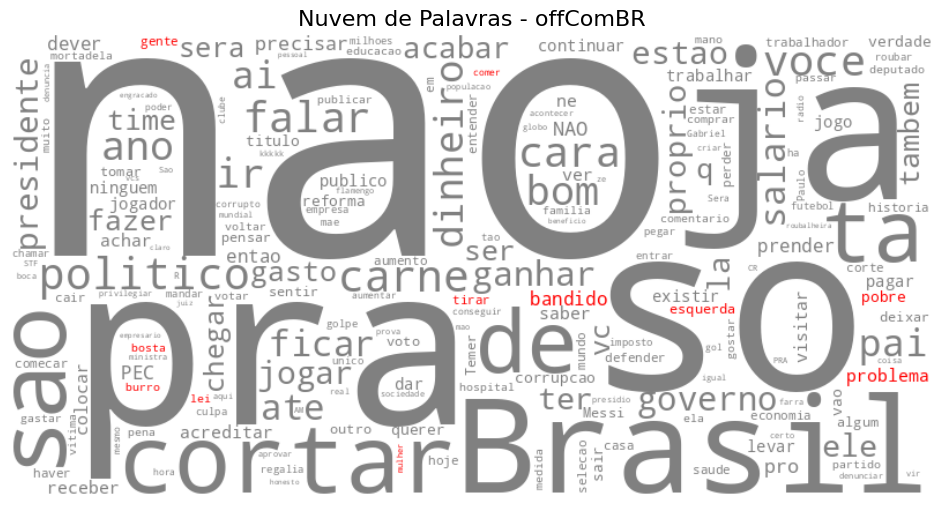

Nuvem de Palavras dataset: olidBR


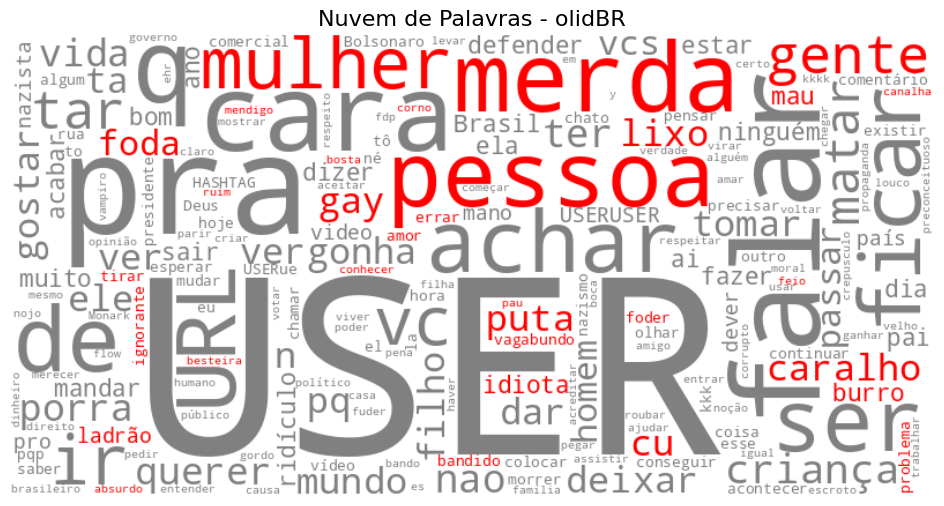

Nuvem de Palavras dataset: fortuna


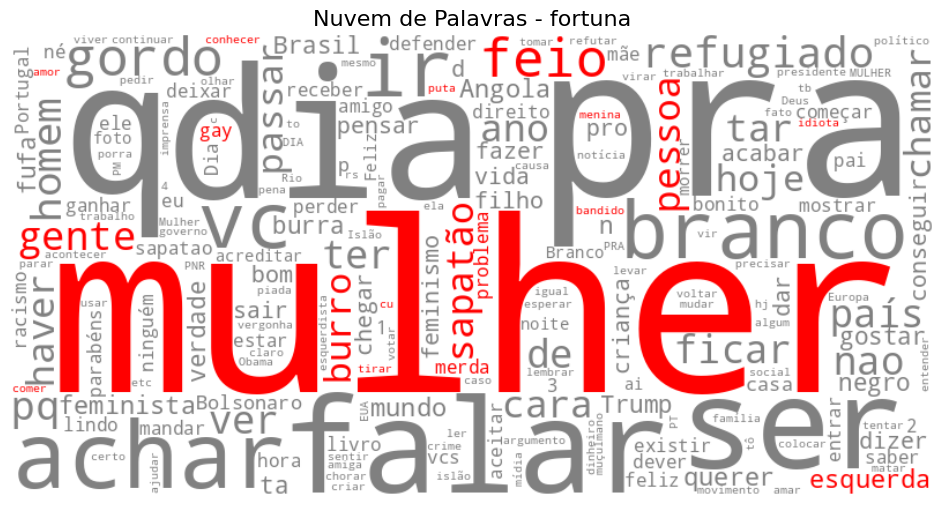

Nuvem de Palavras dataset: toLDBR


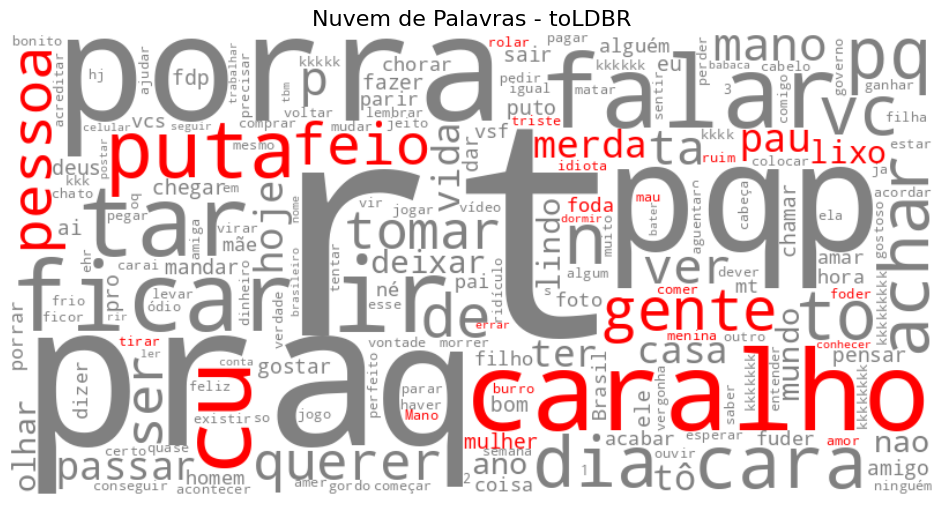

Nuvem de Palavras dataset: tuPyE


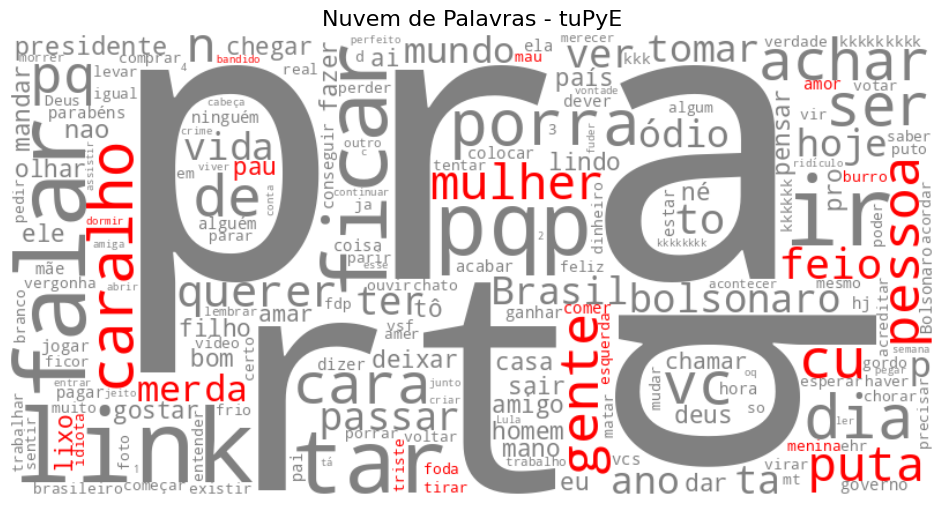

In [ ]:
for nome, caminho in datasets_03.items():
    print(f"Nuvem de Palavras dataset: {nome}")
    
    df = pd.read_csv(caminho)
    nuvem_palavras(df['mensagem'], hatebase, titulo=f"Nuvem de Palavras - {nome}")


In [ ]:
print("mulher" in hatebase) 
#lematizado de mulherinha

True


In [25]:
def plotar_distribuicao_labels(df_plot):
    """Gera o gráfico de barras empilhadas para a distribuição de labels."""
    fig, ax = plt.subplots(figsize=(10, 6))
    posicoes = np.arange(len(df_plot['dataset']))

    ax.barh(posicoes, df_plot['hate'], height=0.6, label='hate', color='#1f77b4')
    ax.barh(posicoes, df_plot['non_hate'], height=0.6, label='non hate', left=df_plot['hate'], color='#ff7f0e')

    ax.set_yticks(posicoes)
    ax.set_yticklabels(df_plot['dataset'])
    ax.invert_yaxis()
    ax.set_xlabel('Porcentagem (%)')
    ax.set_ylabel('Repositório de dados')
    ax.set_title('Distribuição de Labels (Hate vs. Non-Hate) por Dataset')
    ax.set_xlim(0, 100)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plotar_distribuicao_categorias(df_plot, categorias_plot):
    """Gera o gráfico de barras empilhadas para a distribuição de categorias de ódio."""
    fig, ax = plt.subplots(figsize=(10, 6))
    posicoes = np.arange(len(df_plot['dataset']))
    cores = plt.cm.get_cmap('tab20', len(categorias_plot))
    left = np.zeros(len(df_plot))

    for i, categoria in enumerate(categorias_plot):
        if categoria in df_plot.columns:
            valores = df_plot[categoria]
            ax.barh(posicoes, valores, height=0.6, label=categoria, left=left, color=cores(i))
            left += valores

    ax.set_yticks(posicoes)
    ax.set_yticklabels(df_plot['dataset'])
    ax.invert_yaxis()
    ax.set_xlabel('Distribuição Percentual por Categoria (%)')
    ax.set_ylabel('Repositório de dados')
    ax.set_title('Distribuição de Categorias de Ódio nos Datasets')
    ax.set_xlim(0, 100)
    ax.legend(title='Categorias', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

Iniciando processamento dos datasets...

Processando: hateBR
[ X ] Ocorreu um erro inesperado ao processar 'hateBR': 'hate'

Processando: offComBR
[ X ] Ocorreu um erro inesperado ao processar 'offComBR': 'hate'

Processando: olidBR
[ X ] Ocorreu um erro inesperado ao processar 'olidBR': 'hate'

Processando: fortuna
[ X ] Ocorreu um erro inesperado ao processar 'fortuna': 'hate'

Processando: toLDBR
[ X ] Ocorreu um erro inesperado ao processar 'toLDBR': 'hate'

Processando: tuPyE
[ X ] Ocorreu um erro inesperado ao processar 'tuPyE': 'hate'

Processamento concluído!

--- Dados Agregados para Gráfico de Labels ---
    dataset       odio   não odio
0    hateBR  50.000000  50.000000
1  offComBR   0.000000   0.000000
2    olidBR   0.000000   0.000000
3   fortuna  31.534392  68.465608
4    toLDBR  44.071429  55.928571
5     tuPyE  12.033433  87.966567

--- Dados Agregados para Gráfico de Categorias ---
Empty DataFrame
Columns: []
Index: []

--- Gerando Gráficos Finais ---


KeyError: 'hate'

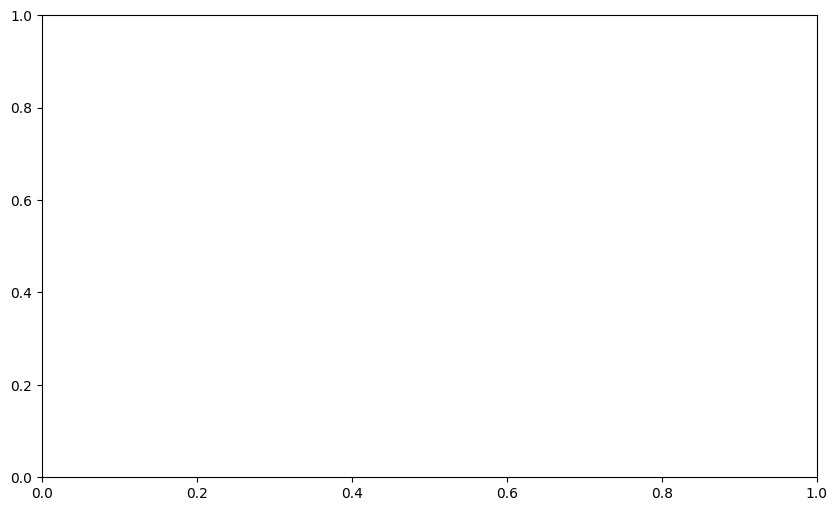

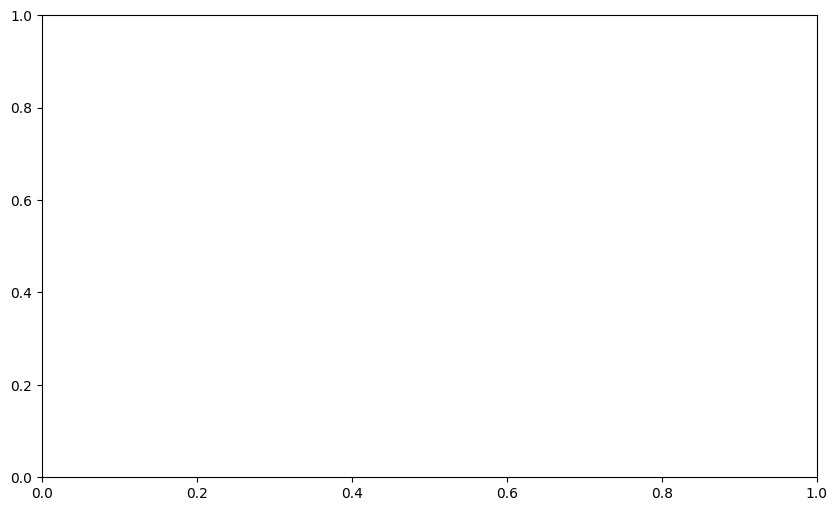

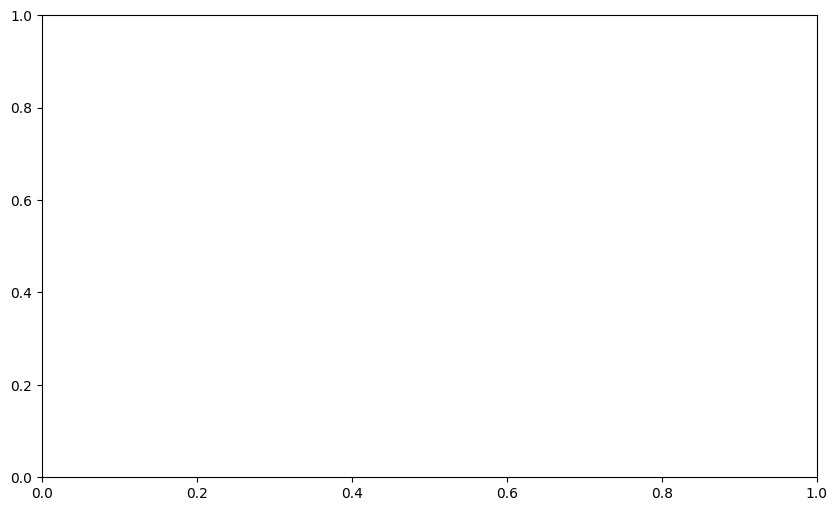

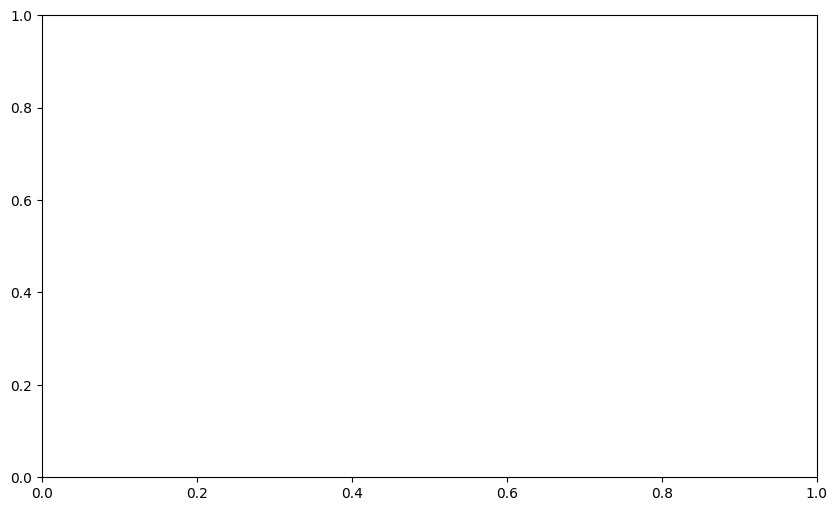

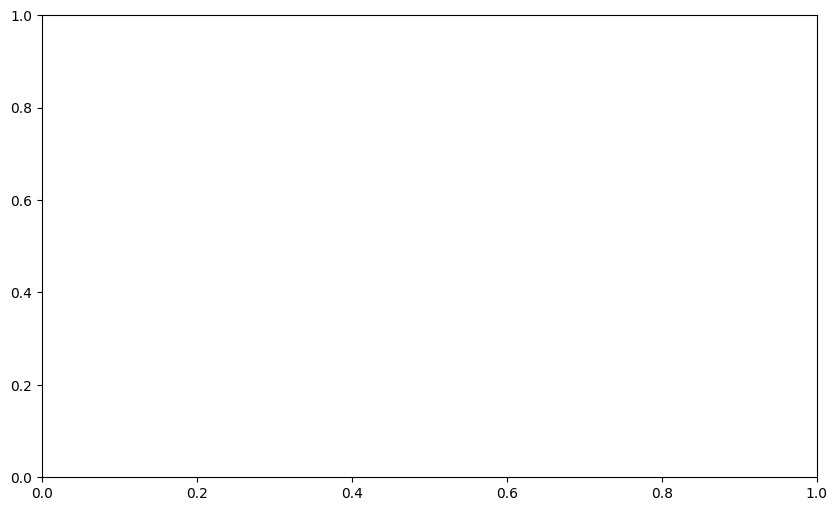

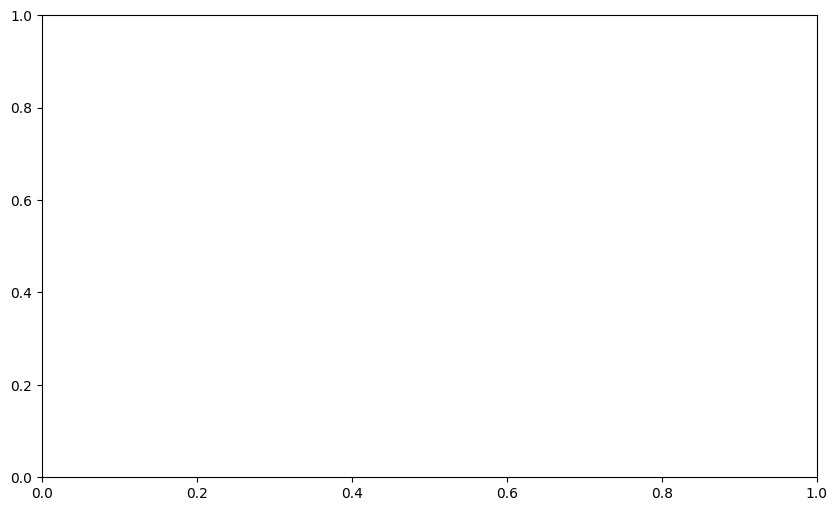

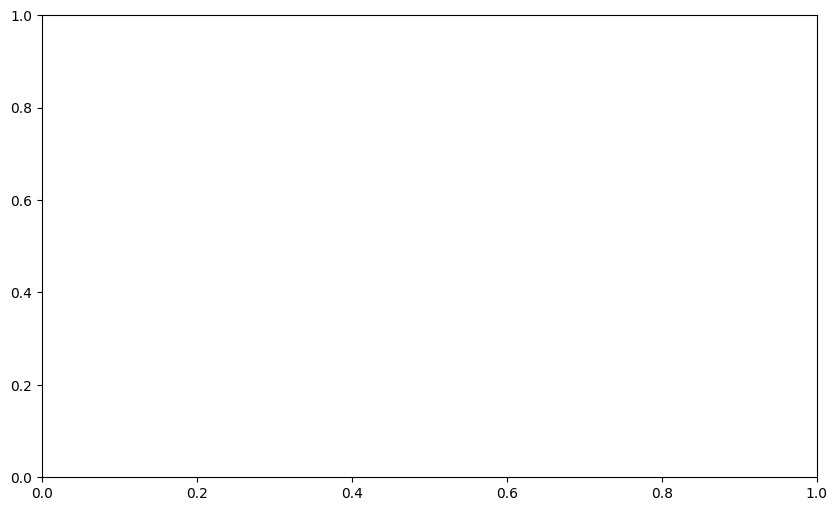

In [36]:

def processar_datasets(datasets_dict: dict, hatebase: dict, categorias: list) -> (pd.DataFrame, pd.DataFrame):
    resultados_labels = []
    resultados_categorias = []

    print("Iniciando processamento dos datasets...")

    for nome, caminho in datasets_dict.items():
        try:
            print(f"\nProcessando: {nome}")
            df = pd.read_csv(caminho)

            # --- Cálculo para o Gráfico 1 (Labels) ---
            # Cálculo da distribuição de labels (odio/não odio)
            dist_labels = df['odio'].value_counts(normalize=True).rename_axis('label').reset_index(name='percentual')
            dist_dict = dict(zip(dist_labels['label'], dist_labels['percentual'] * 100))

            resultado_label = {
                'dataset': nome,
                'odio': dist_dict.get(1, 0),
                'não odio': dist_dict.get(0, 0)
            }
            resultados_labels.append(resultado_label)
            plotar_distribuicao_labels(pd.DataFrame([resultado_label]))

            # --- Cálculo para o Gráfico 2 (Categorias) ---
            df_odio = df.loc[df['odio'] == 1, 'mensagem'].dropna()
            resultado_cat = {'dataset': nome}

            if not df_odio.empty:
                palavras_odio = df_odio.str.lower().str.findall(r'\b\w+\b').explode()
                palavras_no_hatebase = palavras_odio[palavras_odio.isin(list(hatebase.keys()))]
                if not palavras_no_hatebase.empty:
                    categorias_encontradas = palavras_no_hatebase.map(hatebase).explode()
                    dist_percentual = categorias_encontradas.value_counts(normalize=True) * 100

                    for cat, perc in dist_percentual.items():
                        if cat in categorias:
                            resultado_cat[cat] = perc

            # Garante todas as categorias
            for cat in categorias:
                if cat not in resultado_cat:
                    resultado_cat[cat] = 0

            resultados_categorias.append(resultado_cat)

            # Plotar gráfico de categorias individual
            plotar_distribuicao_categorias(pd.DataFrame([resultado_cat]), categorias)

        except FileNotFoundError:
            print(f"[ X ] Arquivo não encontrado para o dataset '{nome}' em: {caminho}")
        except Exception as e:
            print(f"[ X ] Ocorreu um erro inesperado ao processar '{nome}': {e}")

    # Retorna os dados agregados, caso precise usar depois
    df_labels_final = pd.DataFrame(resultados_labels)
    df_categorias_final = pd.DataFrame(resultados_categorias)

    return df_labels_final, df_categorias_final

categorias = ['ps', 'rci', 'pa', 'ddf', 'ddp', 'dmc', 'is', 'or', 'an', 'asm', 'asf', 'pr', 'om', 'qas', 'cds', 're', 'svp']

# 2. Chame a função de processamento
df_labels_final, df_categorias_final = processar_datasets(datasets_03, hatebase, categorias)


# 3. Verifique e plote os resultados
print("\nProcessamento concluído!")
print("\n--- Dados Agregados para Gráfico de Labels ---")
print(df_labels_final)
print("\n--- Dados Agregados para Gráfico de Categorias ---")
print(df_categorias_final)

# 4. Chame as funções de plotagem
# (Assumindo que as funções plotar_distribuicao_labels e plotar_distribuicao_categorias já foram definidas)
print("\n--- Gerando Gráficos Finais ---")
plotar_distribuicao_labels(df_labels_final)
plotar_distribuicao_categorias(df_categorias_final, categorias)